In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
tqdm.pandas()
sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_to_base_results: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr/ppl/starr/val/'
file_name: str = 'train-tokens-total_nonPAD-true_val=2400000000-ckpt_val=2400000000-persist'
N_SPECIAL_TOKENS: int = 7 # number of special tokens in tokenizer (useful for offseting to realign with original CLMBR vocab)

# Stability of Calculating PPL v. # Patients Sampled

How stable is our estimate of val/ppl v. number of patients?

**Experiment:**
* Calculate val/ppl for same model across 1k, 5k, 10k, 20k val patients and measure deviation.

NOTE: It takes ~2.5 hrs for 10k patients.

Run these commands to generate results used in this section:

```bash
# Stability of PPL
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 1000 # 0.1 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 5000 # 0.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 10000 # 2.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 50000 # 5.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 100000
```

In [4]:
path_to_1k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=1000-is_config=False')
path_to_5k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=5000-is_config=False')
path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
path_to_50k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=50000-is_config=False')
path_to_100k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=100000-is_config=False')

def parse_json(path: str) -> Dict:
    df = pd.read_parquet(path + '.parquet')
    mean_loss_per_token = df['label_log_prob'].mean()
    median_loss_per_token = df['label_log_prob'].median()
    mean_ppl_per_token = df['label_ppl'].mean()
    median_ppl_per_token = df['label_ppl'].median()
    ppl = np.exp(-mean_loss_per_token)
    return { 
        'mean_loss_per_token' : mean_loss_per_token, 
        'median_loss_per_token' : median_loss_per_token, 
        'overall_ppl': ppl,
        'mean_ppl_per_token': mean_ppl_per_token, 
        'median_ppl_per_token': median_ppl_per_token, 
    }

df = pd.DataFrame({
    '1k': parse_json(os.path.join(path_to_1k, file_name)),
    '5k': parse_json(os.path.join(path_to_5k, file_name)),
    '10k': parse_json(os.path.join(path_to_10k, file_name)),
    '50k': parse_json(os.path.join(path_to_50k, file_name)),
    '100k': parse_json(os.path.join(path_to_100k, file_name)),
}).T
df

,mean_loss_per_token,median_loss_per_token,overall_ppl,mean_ppl_per_token,median_ppl_per_token
1k,-2.204538,-1.615794,9.066060,7317.615193,5.031883
5k,-2.164920,-1.586860,8.713906,15497.923462,4.888376
10k,-2.108939,-1.533893,8.239493,22352.920333,4.636191
50k,-2.133316,-1.555288,8.442814,18175.526610,4.736449
100k,-2.121963,-1.541915,8.347507,16062.312938,4.673532


# What does the PPL distribution look like?

Let's do some EDA.

In [5]:
df = pd.read_parquet(os.path.join(path_to_10k, file_name) + '.parquet')

In [6]:
def print_percentiles(values: pd.Series):
    percentiles = [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 95, 99, 100]
    percentile_values = np.percentile(values, percentiles)
    df_percentiles = pd.DataFrame({
        'percentile': percentiles,
        'value': percentile_values
    })
    with pd.option_context('display.float_format', lambda x: '%.3f' % x):
        print("==== Percentiles ====")
        print(df_percentiles)

with pd.option_context('display.float_format', lambda x: '%.3f' % x):
    print("==== Overview ====")
    print(df['label_ppl'].describe())
    print_percentiles(df['label_ppl'])

==== Overview ====
count       6392122.000
mean          22352.920
std        11580030.136
min               1.000
25%               1.706
50%               4.636
75%              18.980
max     21731499960.477
Name: label_ppl, dtype: float64
==== Percentiles ====
    percentile           value
0            0           1.000
1           10           1.067
2           20           1.410
3           30           2.050
4           40           3.058
5           50           4.636
6           60           7.250
7           70          12.952
8           80          30.844
9           90         146.397
10          95         666.593
11          99       14488.989
12         100 21731499960.477


In [7]:
# Who is the major outlier?
df.iloc[df['label_ppl'].argmax()]

pid                                                    30584426
n_events                                                  58524
n_tokens                                                  13748
token_idx                                                   199
label                                                     33136
label_log_prob                                       -23.802029
argmax_label                                                253
argmax_log_prob                                       -0.270234
label_ppl                                    21731499960.477451
label_as_token                                 SNOMED/396338004
label_as_token_desc                Metachromatic leukodystrophy
argmax_ppl                                             1.310271
argmax_as_token         SNOMED/78564009 || None || 94.0 - 101.0
argmax_as_token_desc                                 Pulse rate
Name: 5668724, dtype: object

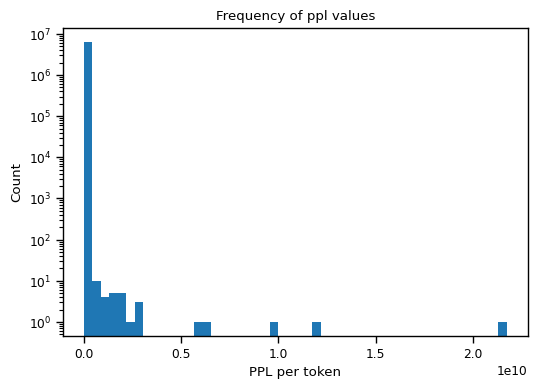

In [8]:
plt.figure(figsize=(6, 4))
plt.hist(df['label_ppl'], bins=50, log=True)  # Apply log scale to y-axis (or x-axis if needed)
plt.xlabel('PPL per token')
plt.ylabel('Count')
plt.title('Frequency of ppl values')
plt.show()

## PPL v. token position

Given a token's location in a sequence, what is the median ppl we can expect?

**Experiment:**
* Run `gpt-base-1024--clmbr` on validation patients, track the ppl for each token, then plot the median ppl observed at each sequence position 

NOTE: Use median instead of mean due to huge right skew outliers

In [9]:
print_percentiles(df[df['token_idx'] == 0]['label_ppl'])
print_percentiles(df[df['token_idx'] == 1]['label_ppl'])
print_percentiles(df[df['token_idx'] == 2]['label_ppl'])

==== Percentiles ====
    percentile       value
0            0       2.369
1           10       2.369
2           20       2.369
3           30       2.369
4           40       2.369
5           50       2.971
6           60       2.971
7           70       7.038
8           80       7.038
9           90      17.102
10          95      17.102
11          99     307.342
12         100 3151528.023
==== Percentiles ====
    percentile        value
0            0        1.000
1           10        1.004
2           20        1.004
3           30        1.008
4           40        4.040
5           50        4.210
6           60        6.023
7           70       10.815
8           80       15.481
9           90      207.375
10          95     1945.232
11          99    83385.286
12         100 94606997.856
==== Percentiles ====
    percentile         value
0            0         1.000
1           10         1.139
2           20         1.207
3           30         1.207
4           40     

In [10]:
def calculate_ppl_per_token_pos(df: pd.DataFrame, min_token_count: int = 30) -> pd.DataFrame:
    """Calculate token position v. median val/ppl"""

    # Count token position frequencies
    df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index()

    # Filter out any token positions with < min_token_count occurrences
    keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_token_count]['token_idx'].tolist()
    print(f"Keeping {len(keep_token_idxs)} token positions (i.e. all token positions with >= {min_token_count} data points)")

    df_pos_to_ppl = []
    for token_idx in tqdm(keep_token_idxs, desc='Processing token positions'):
        # 1. Calculate median PPL for this token positions
        df_token_idx = df[df['token_idx'] == token_idx]
        median = df_token_idx['label_ppl'].median()
        # 2. Calculate 95% CI
        # Sort the data
        sorted_data = df_token_idx['label_ppl'].sort_values().values
        n = len(sorted_data)
        # Calculate the ranks for the 95% confidence interval
        lower_rank = int(np.floor(0.5 * n - 1.96 * np.sqrt(n) / 2))
        upper_rank = int(np.ceil(0.5 * n + 1.96 * np.sqrt(n) / 2))
        lower_rank = max(0, lower_rank)
        upper_rank = min(n - 1, upper_rank)
        lower_bound = sorted_data[lower_rank]
        upper_bound = sorted_data[upper_rank]
        df_pos_to_ppl.append({
            'token_idx': token_idx,
            'median': median,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
    df_pos_to_ppl = pd.DataFrame(df_pos_to_ppl)
    df_pos_to_ppl['ema_median'] = df_pos_to_ppl['median'].ewm(span=20, adjust=False).mean()
    return df_pos_to_ppl

def plot_token_idx_v_ppl(df_pos_to_ppl: pd.DataFrame, ctx_length: int, is_use_ema: bool = False, is_show_ci: bool = False, is_zoom_to_ctx: bool = False):
    """Plot token position v. median PPL"""
    assert 'token_idx' in df_pos_to_ppl.columns, "token_idx column not found in df_pos_to_ppl"
    assert 'lower_bound' in df_pos_to_ppl.columns, "lower_bound column not found in df_pos_to_ppl"
    assert 'upper_bound' in df_pos_to_ppl.columns, "upper_bound column not found in df_pos_to_ppl"
    plt.figure(figsize=(6, 4))
    if is_use_ema:
        # Use exponential moving average of median PPL
        assert 'ema_median' in df_pos_to_ppl.columns, "ema_median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['ema_median'], label='Median PPL (EMA)')
    else:
        # Use raw median PPL
        assert 'median' in df_pos_to_ppl.columns, "median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
    if is_show_ci:
        plt.fill_between(df_pos_to_ppl['token_idx'], df_pos_to_ppl['lower_bound'], df_pos_to_ppl['upper_bound'], alpha=0.3, color='green', label='95% CI')
    plt.xlabel('Token position')
    plt.ylabel('Median PPL')
    plt.title('Token position v. Median PPL' + (' (EMA)' if is_use_ema else ''))
    plt.axvline(x=ctx_length-1, color='red', linestyle='--', label=f'ctx length = {ctx_length}')
    if is_zoom_to_ctx:
        plt.xlim(-10, ctx_length + 100)
        plt.ylim(2, 8)
    plt.legend()
    plt.show()

Keeping 20383 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 20383/20383 [02:12<00:00, 153.71it/s]


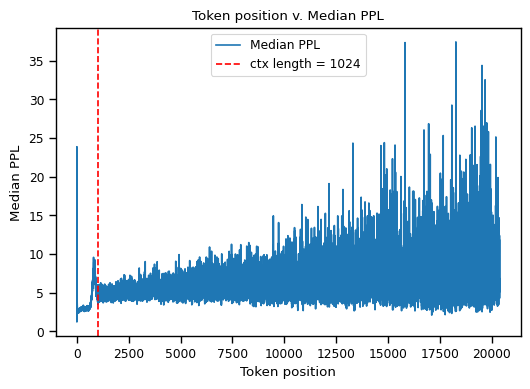

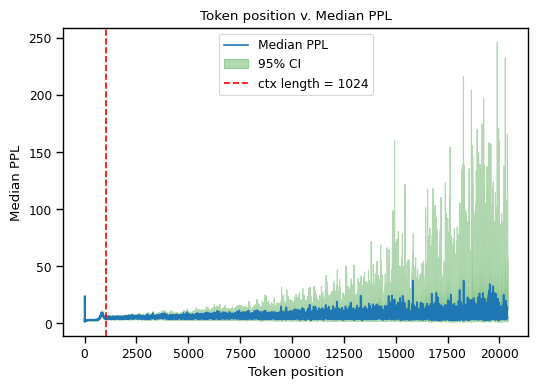

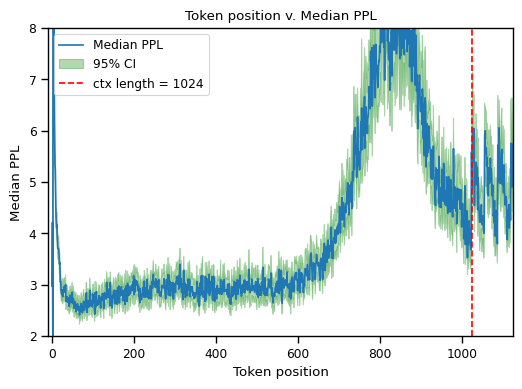

NameError: name 'min_token_count' is not defined

In [11]:
# Calculate median ppl per token position
df_pos_to_ppl = calculate_ppl_per_token_pos(df)

# Plot (without CI)
plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=False, is_zoom_to_ctx=False)

# Plot (with CI)
plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=True, is_zoom_to_ctx=False)
# Plot (with CI) zoomed into ctx length
plot_token_idx_v_ppl(df_pos_to_ppl, ctx_length=1024, is_show_ci=True, is_zoom_to_ctx=True)

# Print count of measurements per token position
df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index()
keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_token_count]['token_idx'].tolist()
plt.scatter(df_token_position_counts[df_token_position_counts['token_idx'].isin(keep_token_idxs)]['token_idx'], 
         df_token_position_counts[df_token_position_counts['token_idx'].isin(keep_token_idxs)]['count'],
         s=2)
plt.xlabel('Token position')
plt.axvline(x=1024, color='red', linestyle='--', label='ctx length = 1024')
plt.ylabel('# of data points')
plt.title('# of data points per token position in Median PPL plot')
plt.show()

Note: There's some unfortunate PPL cyclicality due to the stride length being 32

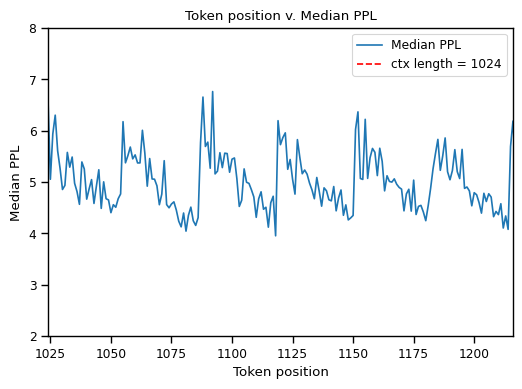

In [ ]:
# Plot artifact of stride length = 32
plt.figure(figsize=(6, 4))
plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
plt.xlabel('Token position')
plt.ylabel('Median PPL')
plt.title('Token position v. Median PPL')
plt.axvline(x=1024, color='red', linestyle='--', label='ctx length = 1024')
plt.xlim(1024, 1024 + 32 * 6)
plt.ylim(2, 8)
plt.legend()
plt.show()

# What's going on at that peak?

What are the tokens causing the weird peak `token_idx` 850?

**Hypos:**
* It could just be that the absolute positional embeddings between 850-1000 are undertrained in the model
    * To test this, see if peak is observed with diff ctxt length gpt base models
* It could be that most patient timelines end at that token position? [FALSE]
    * To test this, plot the dist. of lengths of patient timelines in val split
* It could be a few tokens?
    * To test this, come up with a list of highest mean/median ppl scoring tokens

### Hypo: Caused by patient timeline lengths in Val dataset truncating around `token_idx`

Verdict: False

Idea: If most val patient timelines end around `token_idx` 850, so we're catching the "final days" of lots of patients here (which are harder to predict)

In [12]:
df_n_tokens_counts = df.groupby('pid').agg({ 'n_tokens': 'first' }).reset_index()['n_tokens'].value_counts().reset_index()
print_percentiles(df_n_tokens_counts['n_tokens'])
plt.scatter(df_n_tokens_counts['n_tokens'], df_n_tokens_counts['count'], s=2)
plt.xlabel('Length of patient timeline (# of tokens)')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.title('Patient timeline lengths')
plt.show()

NameError: name 'df' is not defined

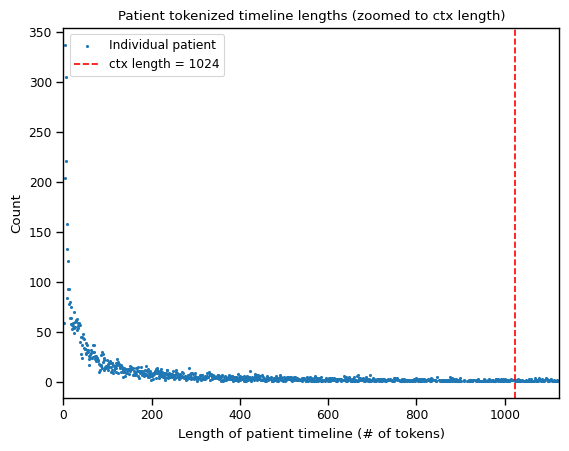

In [52]:
# Zoom in on 0 - ctx length
plt.scatter(df_n_tokens_counts['n_tokens'], df_n_tokens_counts['count'], s=2, label='Individual patient')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.xlabel('Length of patient timeline (# of tokens)')
plt.ylabel('Count')
plt.xlim(0, 1024 + 100)
plt.legend()
plt.title('Patient tokenized timeline lengths (zoomed to ctx length)')
plt.show()

### Hypo: Caused by stride length

Verdict: False -- seems to be an issue indep of stride length

Idea: Stride length is causing weird oscillations of ~32 tokens.

Experiment: Try a diff stride length

Run these commands to generate results used in this section:

```bash
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 57 --n_patients 10000
```

Keeping 20404 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 20404/20404 [02:09<00:00, 157.75it/s]


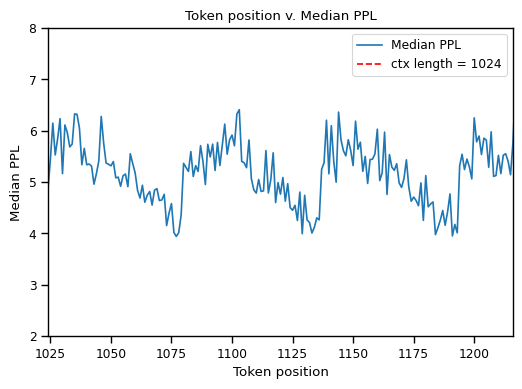

In [7]:
# Plot artifact of stride length = 57
path_to_57 = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=57-n_patients=10000-is_config=False')
df_57 = pd.read_parquet(os.path.join(path_to_57, file_name) + '.parquet')
df_57__pos_to_ppl = calculate_ppl_per_token_pos(df_57)

plt.figure(figsize=(6, 4))
plt.plot(df_57__pos_to_ppl['token_idx'], df_57__pos_to_ppl['median'], label='Median PPL')
plt.xlabel('Token position')
plt.ylabel('Median PPL')
plt.title('Token position v. Median PPL')
plt.axvline(x=1024, color='red', linestyle='--', label='ctx length = 1024')
plt.xlim(1024, 1024 + 32 * 6)
plt.ylim(2, 8)
plt.legend()
plt.show()

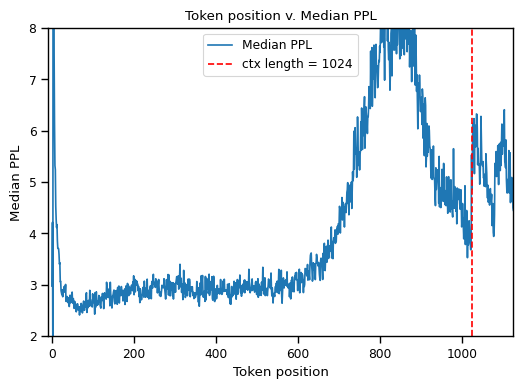

In [9]:
plot_token_idx_v_ppl(df_57__pos_to_ppl, ctx_length=1024, is_show_ci=False, is_zoom_to_ctx=True)

### Hypo: Caused by patient timeline lengths in Train dataset truncating around `token_idx`

Verdict: TBD

Idea: If most training examples are truncated early, then certain positional embeddings will be undertrained

Experiment: Loop through FEMRDataset Dataloader for diff context length values, and plot distribution of lengths of sampled examples

In [32]:
from hf_ehr.utils import load_config_from_path
from hf_ehr.data.tokenization import CLMBRTokenizer
from hf_ehr.data.datasets import BaseDataset
from torch.utils.data import DataLoader
from hf_ehr.trainer.loaders import load_datasets, load_dataloaders
from omegaconf import OmegaConf

# Load config
config = load_config_from_path(os.path.abspath(os.path.join(path_to_base_results, '../../../ckpts/first.ckpt')))
OmegaConf.set_struct(config, False)
config.data.dataset.name = 'FEMRDataset'

# Load dataloader
tokenizer = CLMBRTokenizer( config.data.tokenizer.path_to_config )
datasets: Dict[str, BaseDataset] = load_datasets(config, tokenizer)
dataloaders: Dict[str, DataLoader] = load_dataloaders(config, datasets, tokenizer)

2024-09-10 11:44:46.952 | INFO     | hf_ehr.trainer.loaders:load_dataloaders:30 - ====> Loading ApproxBatchSampler


Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-20_05-22-12/seq_length_per_patient.json` for split=`train`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-21_10-55-32/seq_length_per_patient.json` for split=`val`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-21_11-44-30/seq_length_per_patient.json` for split=`test`


In [22]:
# Loop through train dataloader, keeping track of all sequence lengths seen
if os.path.exists('cache--train_seq_lengths.json'):
    data = json.load(open('cache--train_seq_lengths.json', 'r'))
    train_seq_lengths: List[int] = data['train_seq_lengths']
    assert data['path_to_base_results'] == path_to_base_results, f"Mismatch in path_to_base_results"
else:
    train_seq_lengths: List[int] = []
    for batch in tqdm(dataloaders['train']):
        lengths = batch['tokens']['attention_mask'].sum(dim=1)
        assert len(lengths) == len(batch['patient_ids'])
        train_seq_lengths.extend(lengths)
    train_seq_lengths = [ x.item() for x in train_seq_lengths ]
    json.dump({ 'train_seq_lengths' : train_seq_lengths, 'path_to_base_results' : path_to_base_results, }, open('cache--train_seq_lengths.json', 'w'))
    print("# of batches:", len(dataloaders['train']))
print("# of seqs:", len(train_seq_lengths))

# of seqs: 2567450


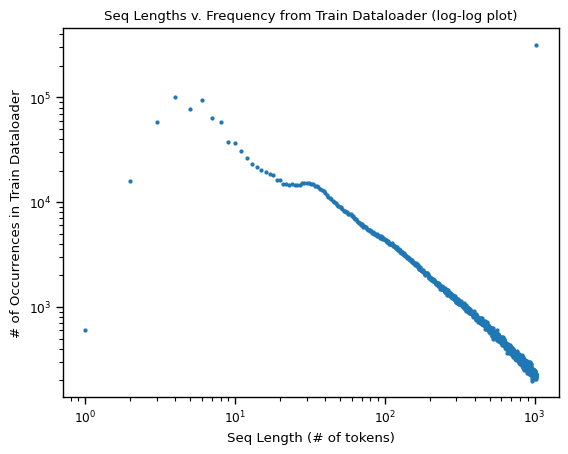

In [27]:
# Plot histogram of sequence lengths
from collections import Counter

counter = Counter(train_seq_lengths)
plt.scatter(list(counter.keys()), list(counter.values()), s=5)
plt.yscale('log')
plt.xscale('log')
plt.title('Seq Lengths v. Frequency from Train Dataloader (log-log plot)')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('# of Occurrences in Train Dataloader')

# Show plot
plt.show()

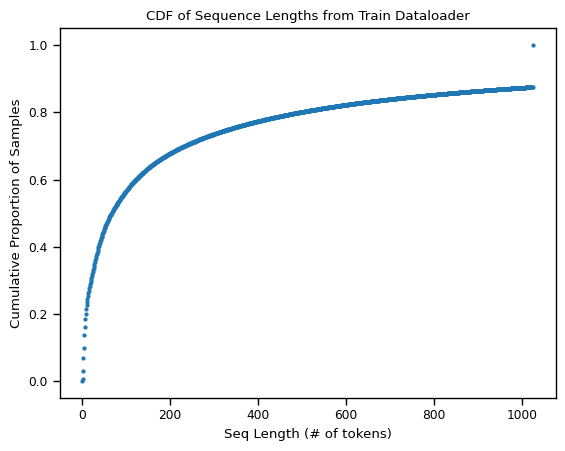

In [30]:
# Plot CDF of sequence lengths
seq_lengths = np.array(list(counter.keys()))
occurrences = np.array(list(counter.values()))
sorted_indices = np.argsort(seq_lengths)
sorted_seq_lengths = seq_lengths[sorted_indices]
sorted_occurrences = occurrences[sorted_indices]

# CDF is the cumulative sum of the occurrences divided by the total number of sequences
cdf = np.cumsum(sorted_occurrences) / np.sum(sorted_occurrences)

# Plot CDF
plt.scatter(sorted_seq_lengths, cdf, marker='o', linestyle='-', s=5)
plt.title('CDF of Sequence Lengths from Train Dataloader')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('Cumulative Proportion of Samples')

# Show plot
plt.show()

In [36]:
# Percentiles
print_percentiles(pd.Series(train_seq_lengths))
print("\n")
print("% of sequences >512", len([ x for x in train_seq_lengths if x > 512 ]) / len(train_seq_lengths))
print("% of sequences >768", len([ x for x in train_seq_lengths if x > 768 ]) / len(train_seq_lengths))
print("% of sequences >1024", len([ x for x in train_seq_lengths if x > 1024 ]) / len(train_seq_lengths))

==== Percentiles ====
    percentile    value
0            0    1.000
1           10    6.000
2           20   10.000
3           30   21.000
4           40   39.000
5           50   68.000
6           60  124.000
7           70  234.000
8           80  495.000
9           90 1024.000
10          95 1024.000
11          99 1024.000
12         100 1024.000


% of sequences >512 0.19588735905275662
% of sequences >768 0.15144403980603321
% of sequences >1024 0.0


### Hypo: Caused by those `token_idx` just being more random

Verdict: Yes, the tokens appear to be more "random" as you get deeper into a patient timeline, per both the **diversity of tokens** and **entropy of tokens** measurements below.

Idea: For some reason, the positions around `token_idx` are literally just weirder tokens. Let's try to measure this without relying on PPL. 

A couple ways:
1. Diversity of tokens: Count % of tokens that appear at each token position which are unique in val dataset
2. Entropy of tokens: Calculate mean/median entropy (according to CLMBR tokenizer) of tokens that appear at each token position in val dataset

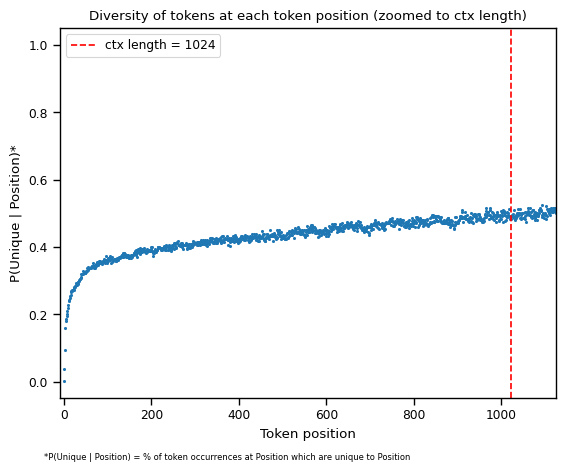

In [94]:
# Diversity of Tokens
#   Count which % of tokens that appear at each token position are unique to that position
df_pos_unique_tokens_pcts = df.groupby('token_idx').agg({ 'label': lambda x: x.nunique() / x.count() }).reset_index().rename(columns={ 'label': 'count' })
plt.scatter(df_pos_unique_tokens_pcts['token_idx'], df_pos_unique_tokens_pcts['count'], s=2)
plt.xlabel('Token position')
plt.ylabel('P(Unique | Position)*')
plt.title('Diversity of tokens at each token position (zoomed to ctx length)')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.legend()
plt.xlim(-10, 1024 + 100)
plt.figtext(0.1, -0.02, "*P(Unique | Position) = % of token occurrences at Position which are unique to Position", ha="left", fontsize=6)
plt.show()

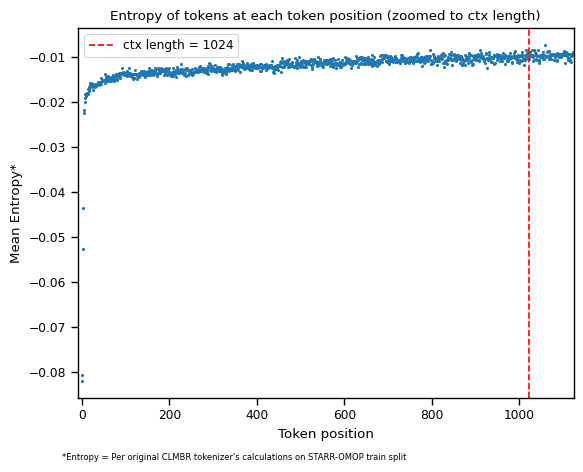

In [93]:
# Entropy of Tokens
#   Calculate mean/median entropy (according to CLMBR tokenizer) of tokens that appear at each token position
# Load CLMBR tokenizer
clmbr_vocab: List[Dict] = json.load(open('/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/clmbr_v8_original_dictionary.json', 'r'))['regular']
label_2_entropy: Dict[int, float] = { idx + N_SPECIAL_TOKENS: token['weight'] for idx, token in enumerate(clmbr_vocab) }
# Calculate entropy of each token
df['entropy'] = df['label'].map(label_2_entropy)
# Calculate mean/median entropy of tokens at each token position
df_pos_entropy = df.groupby('token_idx').agg({ 'entropy': 'mean', }).reset_index()

# Plot
xlim_start, xlim_end = 0, 1024 + 100
plt.scatter(df_pos_entropy.iloc[xlim_start:xlim_end]['token_idx'], df_pos_entropy.iloc[xlim_start:xlim_end]['entropy'], s=2)
plt.xlabel('Token position')
plt.ylabel('Mean Entropy*')
plt.title('Entropy of tokens at each token position (zoomed to ctx length)')
plt.axvline(x=1024-1, color='red', linestyle='--', label='ctx length = 1024')
plt.legend()
plt.xlim(xlim_start - 10, xlim_end)
plt.figtext(0.1, -0.02, "*Entropy = Per original CLMBR tokenizer's calculations on STARR-OMOP train split", ha="left", fontsize=6)
plt.show()

### Hypo: Caused by ctx length of 1024

Verdict: TBD

Idea: This is an artifact of using a ctx length of 1024, so test `gpt-base-512`, `2048`, `4096`

### Hypo: Caused by gpt-base model

Verdict: TBD

Idea: This is an artifact of `gpt-base`, so test `mamba-tiny-1024` and `hyena-medium-1024` as well

# What are the most surprising tokens?


**Experiment:**
* Run `gpt-base-1024--clmbr` on validation patients, and measure ppl associated with each token.
* 

# How does ctxt length affect PPL?

Run these commands to generate the results used in this section:

```bash
# PPL across ctx lengths
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-2048--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-512--clmbr --stride 32 --n_patients 10000
```

**Experiment:**
* Run `gpt-base-k--clmbr` models on the same set of validation patients, with $k \in \{512, 1k, 2k, 4k\}$. Measure the overall ppl for each model.

In [96]:
df_ctxs = {}
for k in [ 512, 1024, 2048, 4096 ]:
    path_to_base_results: str = f'/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-{k}--clmbr/ppl/starr/val/'
    path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
    file_name = [ x for x in os.listdir(path_to_10k) if x.endswith('.parquet') ][0]
    df_ctxs[k] = pd.read_parquet(os.path.join(path_to_10k, file_name))
    print(f"Loaded {k} with shape={df_ctxs[k].shape}")

Loaded 512 with shape=(6380620, 14)
Loaded 1024 with shape=(7407861, 14)
Loaded 2048 with shape=(6400057, 14)
Loaded 4096 with shape=(6406221, 14)


In [101]:
for k in [ 512, 1024, 2048, 4096 ]:
    print(f">>>>>>>> Ctxt = {k} <<<<<<<<")
    print_percentiles(df_ctxs[k]['label_ppl'])

>>>>>>>> Ctxt = 512 <<<<<<<<


==== Percentiles ====
    percentile          value
0            0          1.000
1           10          1.187
2           20          1.918
3           30          3.141
4           40          5.090
5           50          8.308
6           60         14.798
7           70         30.998
8           80         87.384
9           90        472.712
10          95       2135.756
11          99      37165.962
12         100 3843182847.201
>>>>>>>> Ctxt = 1024 <<<<<<<<
==== Percentiles ====
    percentile           value
0            0           1.000
1           10           1.058
2           20           1.384
3           30           2.037
4           40           3.102
5           50           4.760
6           60           7.510
7           70          13.610
8           80          33.210
9           90         164.178
10          95         765.303
11          99       16672.829
12         100 21648180707.099
>>>>>>>> Ctxt = 2048 <<<<<<<<
==== Percentiles ====
    percentile      

In [103]:
# Calculate median PPL per token position
df_ctxs__pos_to_ppl = {}
for k in [ 512, 1024, 2048, 4096 ]:
    df_ctxs__pos_to_ppl[k] = calculate_ppl_per_token_pos(df_ctxs[k])
    df_ctxs__pos_to_ppl[k]['ema_median'] = df_ctxs__pos_to_ppl[k]['median'].ewm(span=20, adjust=False).mean()

Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions:   0%|          | 24/9919 [00:00<01:27, 113.61it/s]

Processing token positions: 100%|██████████| 9919/9919 [01:06<00:00, 148.29it/s]


Keeping 10975 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 10975/10975 [01:30<00:00, 120.63it/s]


Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 9919/9919 [01:07<00:00, 146.10it/s]


Keeping 9919 token positions (i.e. all token positions with >= 100 data points)


Processing token positions: 100%|██████████| 9919/9919 [01:07<00:00, 147.84it/s]


>>>>>>>> Ctxt = 512 <<<<<<<<


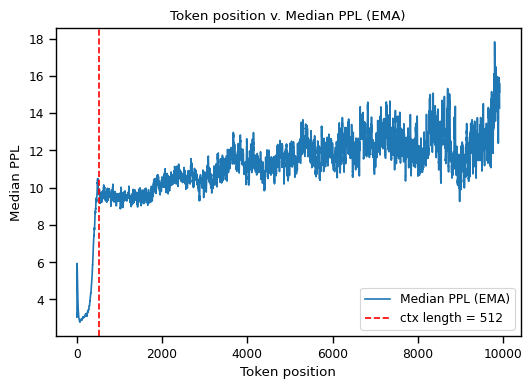

>>>>>>>> Ctxt = 1024 <<<<<<<<


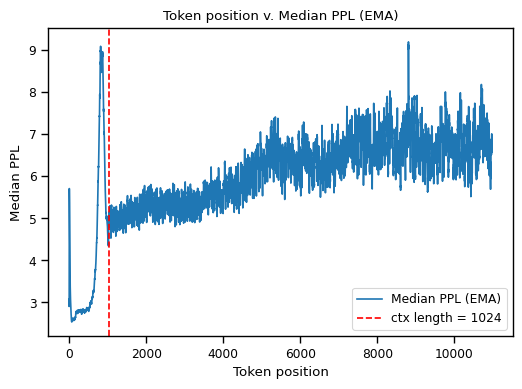

>>>>>>>> Ctxt = 2048 <<<<<<<<


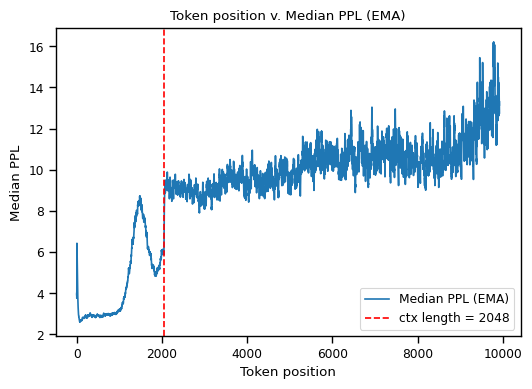

>>>>>>>> Ctxt = 4096 <<<<<<<<


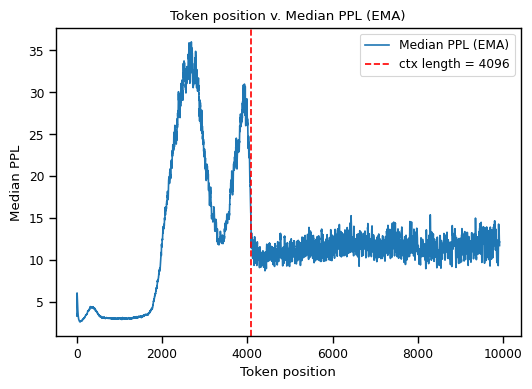

In [148]:
# Plot median PPL per token position for each ctx length
for k in [ 512, 1024, 2048, 4096 ]:
    print(f">>>>>>>> Ctxt = {k} <<<<<<<<")
    plot_token_idx_v_ppl(df_ctxs__pos_to_ppl[k], ctx_length=k, is_use_ema=True, is_show_ci=False, is_zoom_to_ctx=False)

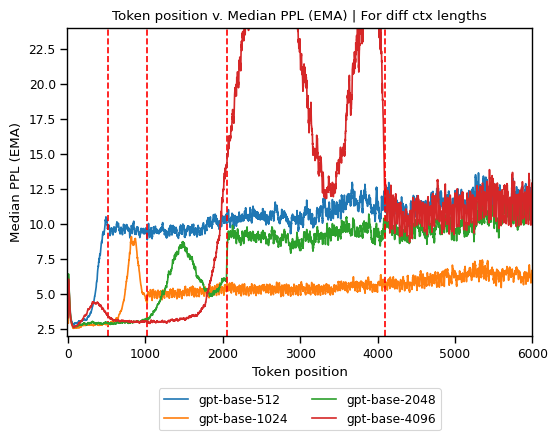

In [150]:
# Show all on same plot
plt.figure(figsize=(6, 4))
for k in [ 512, 1024, 2048, 4096 ]:
    plt.plot(df_ctxs__pos_to_ppl[k]['token_idx'], df_ctxs__pos_to_ppl[k]['ema_median'], label=f'gpt-base-{k}')
    plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff ctx lengths')
plt.xlim(-10, 6000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [132]:
# Plot PPL for first k tokens across diff models
token_span_start, token_span_end = 0, 4096
df_r = []
valid_pids = df_ctxs[512]['pid'].value_counts()[df_ctxs[512]['pid'].value_counts() >= token_span_end].index # only keep pids that have at least `token_span_end` tokens
for k in [ 512, 1024, 2048, 4096 ]:
    df_ = df_ctxs[k]
    # Filter to valid pids
    df_ = df_[df_['pid'].isin(valid_pids)]
    assert df_['pid'].nunique() == len(valid_pids), f"Not all pids were found for k={k}"
    # Calculate PPL for first k tokens
    ppl = np.exp(-df_[(token_span_start <= df_['token_idx']) & (df_['token_idx'] <= token_span_end)]['label_log_prob'].mean())
    df_r.append({
        'ctx_length': k,
        'ppl': ppl
    })
df_r = pd.DataFrame(df_r)
df_r

AssertionError: Not all pids were found for k=1024

# How does model architecture affect PPL?

Run these commands to generate the results used in this section:

```bash
# PPL across ctx lengths
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/mamba-tiny-16384--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/hyena-medium-16384--clmbr --stride 32 --n_patients 10000
```

**Experiment:**
* Run `m-k--clmbr` on the same set of validation patients, with $m \in \{ \text{gpt}, \text{hyena}, \text{mamba} \}$ and $k \in \{1k, 4k, 16k\}$. Measure the overall ppl for each model.

In [15]:
# Load data for all models/ctx lengths
df_models = {} # [key] = (model, ctx_length), [value] = df
for m in [ 'gpt-base', 'mamba-tiny', 'hyena-large', 'llama-base']:
    for k in [ 512, 1024, 2048, 4096, 8192, 16384,]:
        path_to_base_results: str = f'/share/pi/nigam/suhana/hf_ehr/cache/runs_backup/{m}-{k}--clmbr/ppl/starr/val/'
        path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False')
        if not os.path.exists(path_to_10k):
            print(f'Dir not found: {path_to_10k}')
            continue
        file_name = [ x for x in os.listdir(path_to_10k) if x.endswith('.parquet') ][0]
        df_models[(m,k)] = pd.read_parquet(os.path.join(path_to_10k, file_name))
        print(f"Loaded {m}-{k} with shape={df_models[(m,k)].shape}")

Loaded gpt-base-512 with shape=(13835144, 14)
Loaded gpt-base-1024 with shape=(13835144, 14)
Loaded gpt-base-2048 with shape=(13835144, 14)
Loaded gpt-base-4096 with shape=(13835144, 14)
Dir not found: /share/pi/nigam/suhana/hf_ehr/cache/runs_backup/gpt-base-8192--clmbr/ppl/starr/val/dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False
Dir not found: /share/pi/nigam/suhana/hf_ehr/cache/runs_backup/gpt-base-16384--clmbr/ppl/starr/val/dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False
Dir not found: /share/pi/nigam/suhana/hf_ehr/cache/runs_backup/mamba-tiny-512--clmbr/ppl/starr/val/dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False
Loaded mamba-tiny-1024 with shape=(13835144, 14)
Dir not found: /share/pi/nigam/suhana/hf_ehr/cache/runs_backup/mamba-tiny-2048--clmbr/ppl/starr/val/dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False
Loaded mamba-tiny-4096 with shape=(13835144, 14)
Loaded mamba-tiny-8192 with shape=(13835144, 14)
Loaded mamba-tiny-

In [16]:
# Calculate median PPL per token position
df_models__pos_to_ppl = {}
for key in df_models.keys():
    df_models__pos_to_ppl[key] = calculate_ppl_per_token_pos(df_models[key])

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:36<00:00, 69.14it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:31<00:00, 69.91it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:32<00:00, 69.78it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:36<00:00, 69.16it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:33<00:00, 69.59it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:29<00:00, 70.27it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:33<00:00, 69.66it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:33<00:00, 69.58it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:28<00:00, 70.47it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:29<00:00, 70.26it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:29<00:00, 70.23it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:28<00:00, 70.44it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:27<00:00, 70.52it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:29<00:00, 70.31it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:28<00:00, 70.34it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:30<00:00, 70.15it/s]


## Save to memory

In [ ]:
out_dir = '/share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/'
for key in df_models__pos_to_ppl.keys():
    file_name = f'val-ppl-{key[0]}-{key[1]}.parquet'
    file_path = os.path.join(out_dir, file_name)
    df_models__pos_to_ppl[key].to_parquet(file_path)
    print(f"Saved {file_path}")

## Reload from memory to avoid recomputations

In [5]:
df_models__pos_to_ppl = {}
out_dir = '/share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/'
for file_name in os.listdir(out_dir):
    match = re.match(r'val-ppl-([\w\-]+)-(\d+)\.parquet', file_name)
    if not match:
        continue
    file_path = os.path.join(out_dir, file_name)
    print("Loading", file_path)
    key_0 = match.group(1)
    key_1 = int(match.group(2))
    print(key_0, key_1)
    df_models__pos_to_ppl[(key_0, key_1)] = pd.read_parquet(file_path)

Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-gpt-base-2048.parquet
gpt-base 2048
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-hyena-large-8192.parquet
hyena-large 8192
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-gpt-base-512.parquet
gpt-base 512
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-mamba-tiny-1024.parquet
mamba-tiny 1024
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-llama-base-512.parquet
llama-base 512
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-hyena-large-1024.parquet
hyena-large 1024
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-mamba-tiny-4096.parquet
mamba-tiny 4096
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-llama-base-4096.parquet
llama-base 4096
Loading /share/pi/nigam/migufuen/ehrshot-benchmark/ehrshot/val-ppl/val-ppl-gpt-base-4096

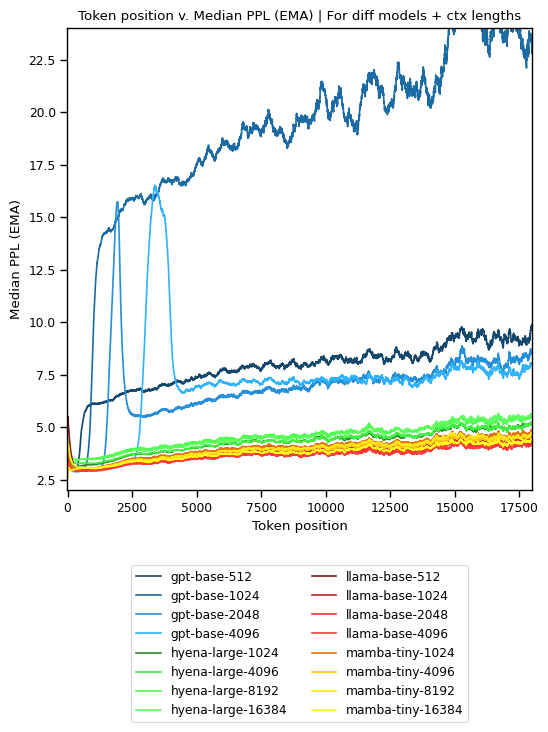

In [6]:
# Show all on same plot
color_map = plt.get_cmap('tab10')  # You can use other colormaps too
model_2_color = {
    'gpt-base': color_map(0),
    'mamba-tiny': color_map(1),
    'hyena-large': color_map(2),
    'llama-base': color_map(3)
}

plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'gpt-base', 'hyena-large', 'llama-base', 'mamba-tiny' ]):
    for k_idx, k in enumerate([ 512, 1024, 2048, 4096, 8192, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        base_color = model_2_color[m][:3]
        brightness_factor = 0.6 + (k_idx * 0.3)
        color = [min(c * brightness_factor, 1) for c in base_color] + [1.0]
        
        plt.plot(df_models__pos_to_ppl[(m, k)]['token_idx'], df_models__pos_to_ppl[(m, k)]['ema_median'],
                 label=f'{m}-{k}', color=color)

        # plt.axvline(x=k, color='red', linestyle='--')  # Adjust the vertical line color


        # color = [min(c + 0.2 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        # plt.plot(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color)
        # plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 18000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

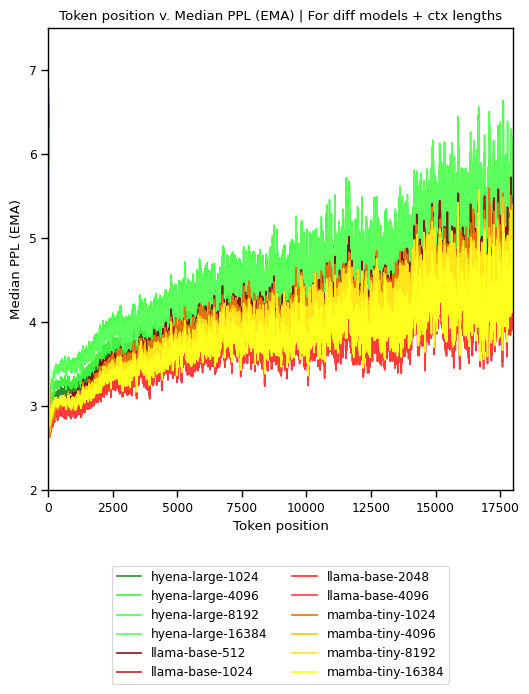

In [44]:
# Without GPT
plt.figure(figsize=(6, 6))
for m_idx, m in enumerate([ 'hyena-large', 'llama-base', 'mamba-tiny']):
    for k_idx, k in enumerate([ 512, 1024, 2048, 4096, 8192, 16384,]):
        if (m,k) not in df_models__pos_to_ppl: continue
        # color = [min(c + 0.3 * k_idx, 1) for c in model_2_color[m][:3]] + [1.0]
        base_color = model_2_color[m][:3]
        brightness_factor = 0.6 + (k_idx * 0.3)
        color = [min(c * brightness_factor, 1) for c in base_color] + [1.0]
        plt.plot(df_models__pos_to_ppl[(m,k)]['token_idx'], df_models__pos_to_ppl[(m,k)]['ema_median'], label=f'{m}-{k}', color=color)
        # plt.axvline(x=k, color='red', linestyle='--')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff models + ctx lengths')
plt.xlim(-10, 18000)
plt.ylim(2, 7.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

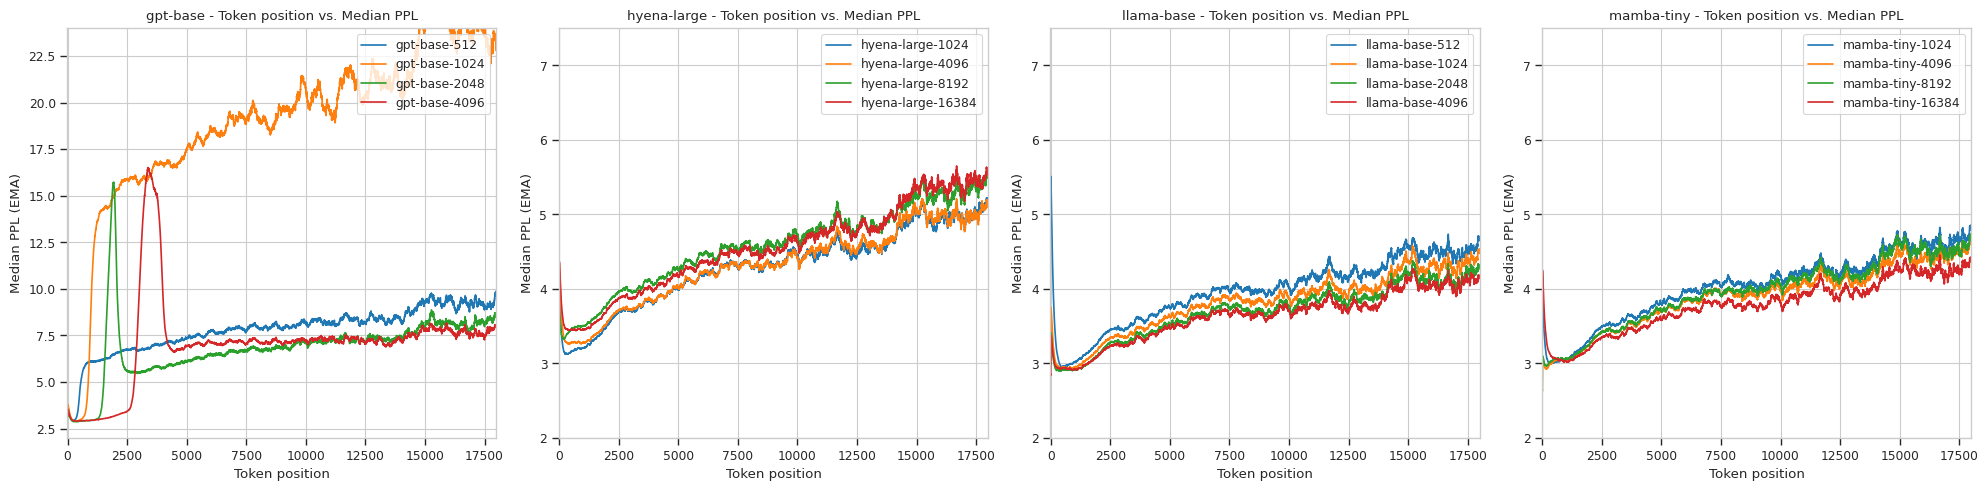

In [7]:
# Set the Seaborn theme
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})  

max_x = {
    'gpt-base': 24,
    'mamba-tiny': 7.5,
    'hyena-large': 7.5,
    'llama-base': 7.5
}
tab10_colors = sns.color_palette("tab10")
models = ['gpt-base', 'hyena-large', 'llama-base', 'mamba-tiny']
context_lengths = [512, 1024, 2048, 4096, 8192, 16384]

# Create subplots (2x2 grid)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy iteration

for m_idx, m in enumerate(models):
    ax = axes[m_idx]  # Select the subplot axis
    color_id = 0
    for k_idx, k in enumerate(context_lengths):
        if (m, k) not in df_models__pos_to_ppl:
            continue
        color = tab10_colors[color_id]
        color_id += 1
        # Plot the data for the current model and context length using Seaborn
        sns.lineplot(x=df_models__pos_to_ppl[(m, k)]['token_idx'],
                     y=df_models__pos_to_ppl[(m, k)]['ema_median'],
                     label=f'{m}-{k}', ax=ax, color=color)

    # Set labels, title, and limits for each subplot
    ax.set_xlabel('Token position')
    ax.set_ylabel('Median PPL (EMA)')
    ax.set_title(f'{m} - Token position vs. Median PPL')
    ax.set_xlim(-10, 18000)
    ax.set_ylim(2, max_x[m])
    ax.legend(loc='upper right')

# Adjust layout to ensure plots don't overlap
plt.tight_layout()
plt.show()

Only Llama-512

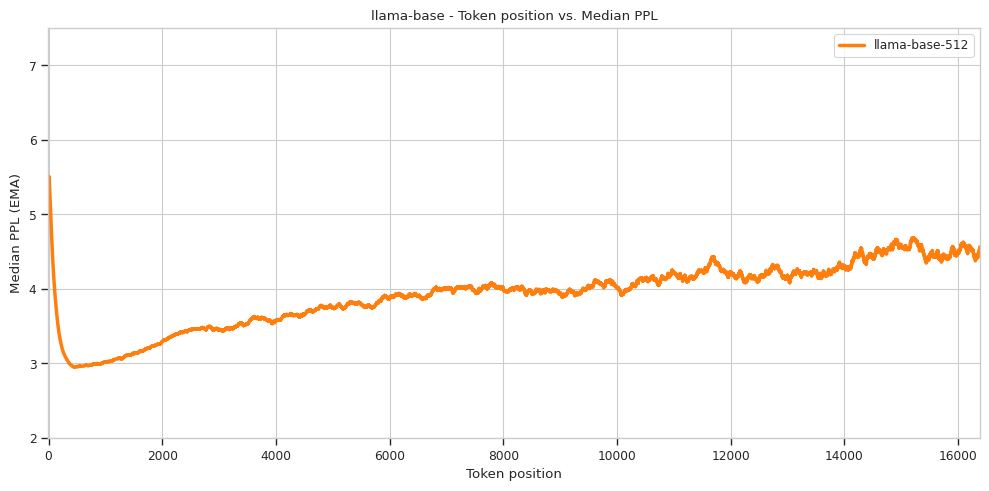

In [9]:
# Set the Seaborn theme
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})  

max_x = {
    'gpt-base': 24,
    'mamba-tiny': 7.5,
    'hyena-large': 7.5,
    'llama-base': 7.5
}
tab10_colors = sns.color_palette("tab10")
# models = ['gpt-base', 'hyena-large', 'llama-base', 'mamba-tiny']
models = ['llama-base']
context_lengths = [512]

# Create subplots (2x2 grid)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
# axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy iteration


color = tab10_colors[1]
# Plot the data for the current model and context length using Seaborn
sns.lineplot(x=df_models__pos_to_ppl[(m, k)]['token_idx'],
                y=df_models__pos_to_ppl[(m, k)]['ema_median'],
                label=f'{m}-{k}', ax=ax, color=color, linewidth=2.5)

# Set labels, title, and limits for each subplot
ax.set_xlabel('Token position')
ax.set_ylabel('Median PPL (EMA)')
ax.set_title(f'{m} - Token position vs. Median PPL')
ax.set_xlim(-10, 16384)
ax.set_ylim(2, max_x[m])
ax.legend(loc='upper right')

# Adjust layout to ensure plots don't overlap
plt.tight_layout()
plt.show()

# How does vocab size affect the presence of outliers?

Run these commands to generate the results used in this section:

```bash
[TODO]
# PPL across vocab sizes
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_16k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_64k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_96k --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr_118k --stride 32 --n_patients 10000
```

Does decreasing the vocab size reduce the frequency of high token-level-ppl predictions?

**Experiment:**
* Run `gpt-base-1024--clmbr_k` on the same set of validation patients, with $k \in \{16k, 40k, 96k, 118k\}$.
* Measure frequency of outliers in terms of token-level-ppl

# 